In [1]:
import cv2
import itertools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
import random
import re


from sklearn.utils import shuffle

from collections import Counter
from unidecode import unidecode as decode

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'cv2'

# EDA and Reduce

In [2]:
root = os.environ['HOME'] + "/Scripts/learn-ai-bbc"

train  = f"{root}/BBC News Train.csv"
test   = f"{root}/BBC News Test.csv"
sample = f"{root}/BBC News Sample Solution.csv"

df_train = pd.read_csv(train)
df_test  = pd.read_csv(test)

In [3]:
df_train

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [4]:
print('missing texts      : ', df_train['Text'].isnull().sum())
print('missing categories : ', df_train['Category'].isnull().sum())
print('duplicate text     : ', df_train['Text'].duplicated().sum())

missing texts      :  0
missing categories :  0
duplicate text     :  50


In [5]:
pd.DataFrame(Counter(df_train[df_train['Text'].duplicated()]['Category']), index=['duplicates'])

,entertainment,tech,politics,sport,business
duplicates,10,27,8,4,1


In [6]:
df_train.drop_duplicates(subset=['Text'], inplace=True)
pd.DataFrame(Counter(df_train['Category']), index=['articles'])

,business,tech,politics,sport,entertainment
articles,335,234,266,342,263


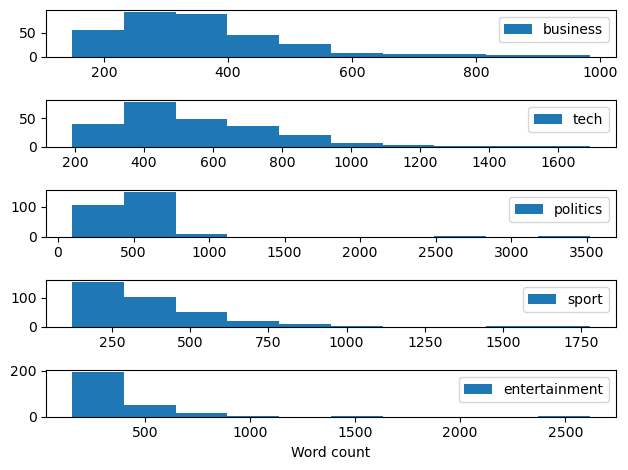

In [7]:
categories = df_train['Category'].drop_duplicates().to_list()

_, fig = plt.subplots(5,1)
for idx, ax in enumerate(fig.ravel()):
    df_cat = df_train[df_train['Category'] == categories[idx]]
    count  = [len(df_cat.iloc[row]['Text'].split(' ')) for row in range(len(df_cat))] 

    ax.hist(count, label=categories[idx])
    ax.legend()

ax.set_xlabel('Word count')
plt.tight_layout()

In [8]:
def top_100(fig, idx, cat):
    all_words = {}
    top_100   = {}

    for article in df_train[df_train['Category'] == cat]['Text']:
        for word in article.split(' '):
            if word in all_words.keys(): all_words[word] += 1
            else:                        all_words[word]  = 1

    all_words = dict(sorted(all_words.items(), key=lambda item: item[1], reverse=True))
    
    for i, key in enumerate(all_words.keys()):
        if i < 30 or i > 129: ## omit top 30 common
            continue
        top_100[key] = all_words[key]

    fig.add_subplot(2, 3, idx+1)
    plt.scatter(top_100.values(), top_100.keys(), label=categories[idx])
    plt.grid(axis='x')
    plt.legend()    
    return

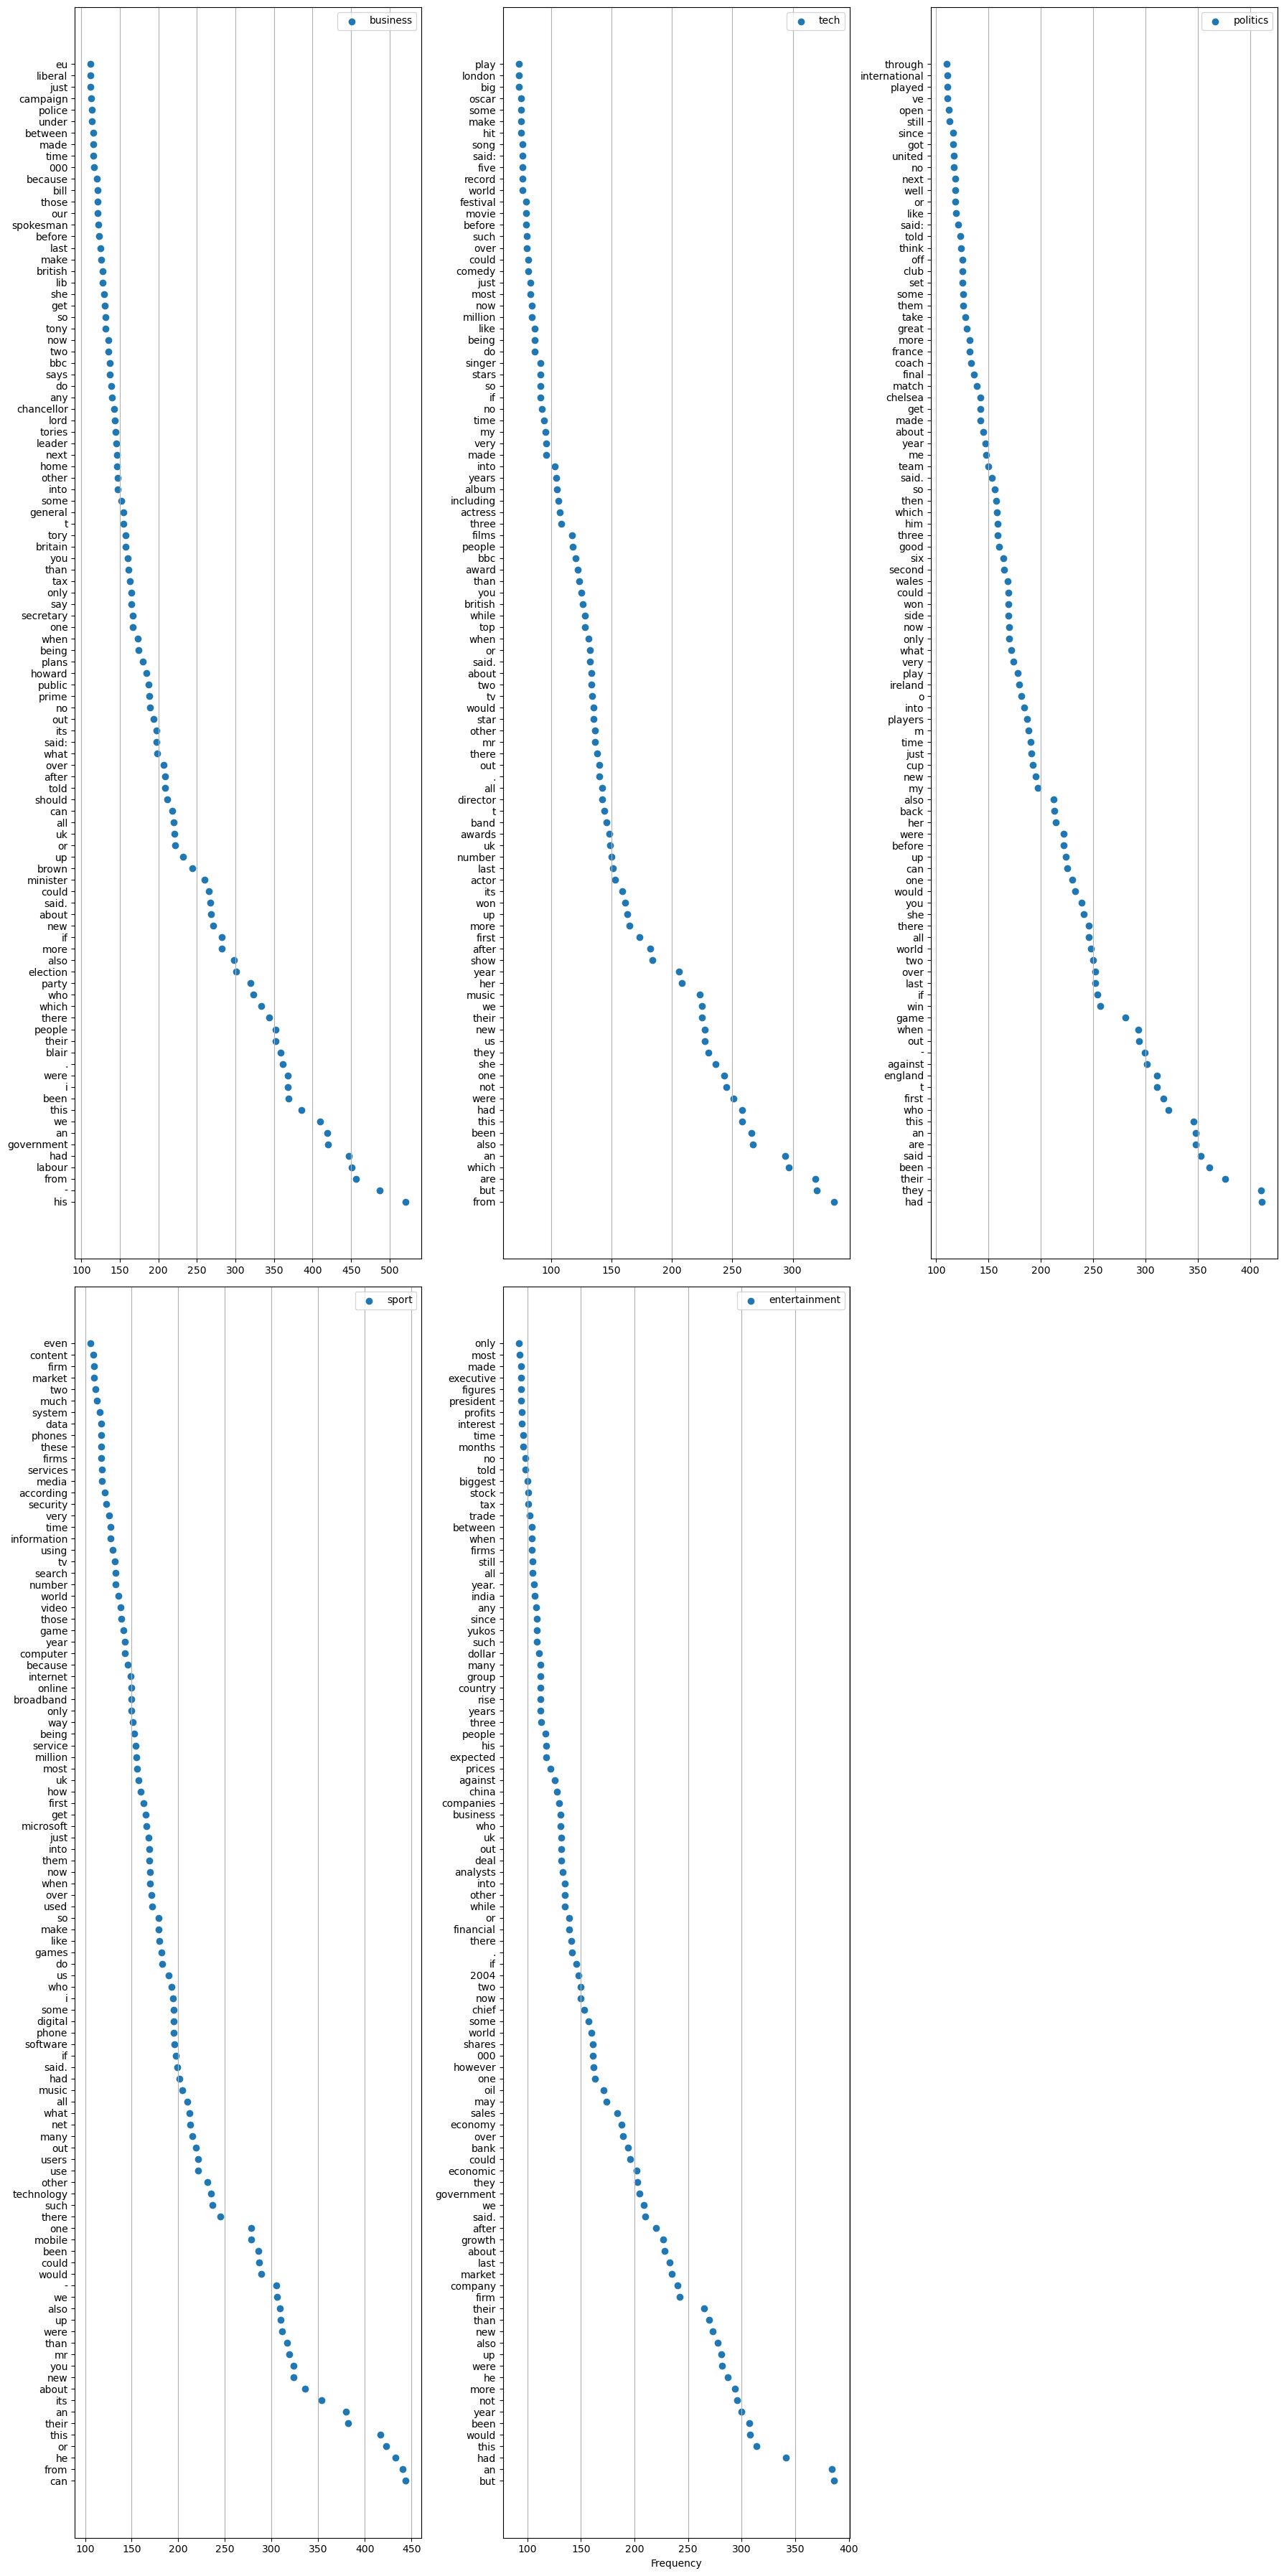

In [9]:
fig = plt.figure(figsize=(18, 36))
for idx, cat in enumerate(categories):
    top_100(fig, idx, cat)
    
_ = plt.xlabel('Frequency')
plt.tight_layout()

Based on first impressions, it looks like the data has already undergone some pre-processing. All the sentences for an article are stored in one long string and, as I skimmed through some of the texts, I noticed many cases of uneven spacing between words which will need adjusting. I barely noticed punctuation marks except periods and currency symbols so those will also need to be removed prior to modeling (including numbers as well).

Although there aren't any missing values, there are 50 duplicate articles that are spread unevenly across all categories. Even though they constitute barely 5% of the total number of articles, I decided to remove them nevertheless. Based on the number of articles in each Category, the total number of articles available in the training dataset seems to be well-balanced. Looking at the top 100 frequent words, it's already obvious what category each set of articles belong to.

I then tokenized the text to make model-training easier. After considering whether to stem or lemmatize the words, I decided to go with lemmatizing because, although they are quite similar, stemming words does tend to alter the fundamental meaning of the word more often than lemmatizing does. By grouping related words, lemmatizing helps improve model accuracy.

In [10]:
def reduce(data):
    tokenized = []
    for article in data:
        redux = re.sub(' +', ' ', article)
        redux = re.sub(r'[^\w\s]+', '', redux)
        redux = re.sub(r'[0-9]+', '', redux)
        redux = decode(redux).lower()

        lemmatize = [WordNetLemmatizer().lemmatize(token) for token in word_tokenize(redux)]
        tokenized.append(' '.join(lemmatize))
    return tokenized

In [11]:
df_train['Tokenized'] = reduce(df_train['Text'])
df_test['Tokenized']  = reduce(df_test['Text'])
df_train

,ArticleId,Text,Category,Tokenized
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizen in a...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron boss in m payout eighteen former enron d...
...,...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment,double eviction from big brother model caprice...
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment,dj double act revamp chart show dj duo jk and ...
1487,1590,weak dollar hits reuters revenues at media gro...,business,weak dollar hit reuters revenue at medium grou...
1488,1587,apple ipod family expands market apple has exp...,tech,apple ipod family expands market apple ha expa...


# Unsupervised Model

In [12]:
def best_guess(df, true):
    best_match = 0 
    categories = {cat : '' for cat in df_train['Category'].drop_duplicates().to_list()}
    
    for combo in itertools.permutations(range(5)):
        for c, cat in zip(combo, categories.keys()):
            categories[cat] = c

        prediction = df['Category'].map(categories)
        accuracy   = accuracy_score(true, prediction)
        if accuracy > best_match: 
            best_match = accuracy
            best_cat   = combo
    return best_match, best_cat

In [13]:
def all_guesses(df, tdf_model, nmf_model):
    tdf_train = tdf_model.fit_transform(df['Tokenized'])
    nmf_train = nmf_model.fit_transform(tdf_train)
    
    nmf_train = np.argsort(nmf_train)
    all_guess = [nmf_train[i][nmf_train.shape[1] - 1] for i in range(nmf_train.shape[0])]
    return best_guess(df, all_guess)

A grid search of the best parameters was run for both models. To find the best parameters for the TF-IDF matrix was computed by using default parameters for the NMF model and vice versa to find the best parameters for the NMF.

In [47]:
max_df_params       = np.arange(0.1, 1.1, .25)
min_df_params       = np.arange(0, 1, .25)
norm_params         = ['l1', 'l2']
use_idf_params      = [True, False]
smooth_idf_params   = [True, False]
sublinear_tf_params = [True, False]

best_acc_1 = 0
for max_df in max_df_params:
    for min_df in min_df_params:
        for norm in norm_params:
            for use_idf in use_idf_params:
                for smooth_idf in smooth_idf_params:
                    for sublinear_tf in sublinear_tf_params:
                        
                        tdf_model = TfidfVectorizer(stop_words   = 'english',
                                                    ngram_range  = (1, 1),
                                                    max_df       = max_df,
                                                    min_df       = min_df,
                                                    norm         = norm,
                                                    use_idf      = use_idf,
                                                    smooth_idf   = smooth_idf,
                                                    sublinear_tf = sublinear_tf)
                        
                        nmf_model = NMF(n_components = 5, random_state = 42)

                        try:    acc, order = all_guesses(df_train, tdf_model, nmf_model)
                        except: continue
                        
                        if acc > best_acc_1:
                            best_acc_1 = acc
                            best_ord_1 = order
                            best_pms_1 = max_df, min_df, norm, use_idf, smooth_idf, sublinear_tf

In [48]:
print('best vec results')
print('accuracy :', best_acc_1)
print('labels   :', best_ord_1)
print('params   :', best_pms_1)

In [49]:
n_comp_params    = [1, 3, 5, 10]
init_params      = ['random', 'nndsvd', 'nndsvda', 'nndsvdar']
solver_params    = ['cd', 'mu']
beta_loss_params = ['frobenius', 'kullback-leibler', 'itakura-saito']
max_iter_params  = [50, 100, 500, 1000]
l1_ratio_params  = np.arange(0, 1.1, .25)

best_acc_2 = 0
for n_comps in n_comp_params:
    for init in init_params:
        for solver in solver_params:
            for beta_loss in beta_loss_params:
                for max_iter in max_iter_params:
                    for l1_ratio in l1_ratio_params:

                        tdf_model = TfidfVectorizer(stop_words = 'english')
                        
                        nmf_model = NMF(n_components = n_comps,
                                  init         = init,
                                  solver       = solver,
                                  beta_loss    = beta_loss,
                                  max_iter     = max_iter,
                                  random_state = 42,
                                  l1_ratio     = l1_ratio)

                        try:    acc, order = all_guesses(df_train, tdf_model, nmf_model)
                        except: continue

                        if acc > best_acc_2:
                            best_acc_2 = acc
                            best_ord_2 = order
                            best_pms_2 = n_comps, init, solver, beta_loss, max_iter, l1_ratio

In [50]:
print('best nmf results')
print('accuracy :', best_acc_2)
print('labels   :', best_ord_2)
print('params   :', best_pms_2)

In [18]:
tdf_model = TfidfVectorizer(stop_words   = 'english',
                            ngram_range  = (1, 1),
                            max_df       = 0.6,
                            min_df       = 0.0,
                            norm         = 'l2',
                            use_idf      = True,
                            smooth_idf   = True,
                            sublinear_tf = True)

nmf_model = NMF(n_components = 5,
                init         = 'nndsvdar',
                solver       = 'mu',
                beta_loss    = 'kullback-leibler',
                max_iter     = 500,
                random_state = 42,
                l1_ratio     = 0.0,
                shuffle      = True)

In [19]:
best_acc, best_order = all_guesses(df_train, tdf_model, nmf_model)
best_categories      = {cat : order for order, cat in zip(best_order, df_train['Category'].drop_duplicates().to_list())}

print('accuracy:', best_acc)
print('category:', best_categories)

accuracy: 0.8840277777777777
category: {'business': 0, 'tech': 3, 'politics': 2, 'sport': 1, 'entertainment': 4}


In [20]:
tdf_test = tdf_model.transform(df_test['Tokenized'])
nmf_test = nmf_model.transform(tdf_test)
nmf_test = np.argsort(nmf_test)

predicts = [nmf_test[i][nmf_test.shape[1] - 1] for i in range(nmf_test.shape[0])]

In [21]:
results  = pd.DataFrame()
results['ArticleId'] = df_test['ArticleId']
results['Category']  = [k for pred in predicts for k, v in best_categories.items() if v == pred]

# results.to_csv(f"{root}/results_unsup.csv", index=False)

With the best parameters found for each model, the accuracy of the training data is found to be 88%. However, the test data accuracy turned out to be 93% (0.92789). Unless the model performing better on the test data is an absolute fluke, this suggests the model could be underfitting the training data. There could also be a case of data leakage, where the model becomes unrealistic due to information from the test data mixing with the training data.

# Supervised Model

A similar approach to the unsupervised model was taken whereby a grid search was performed to find the best parameters for the chosen supervised model (KMeans).

In [45]:
n_cluster_params = [2, 4, 8, 16]
init_params      = ['k-means++', 'random']
n_init_params    = ['auto', 1, 3, 5]
max_iter_params  = [50, 100, 500, 1000]
algorithm_params = ['lloyd', 'elkan']

best_acc_3 = 0
for n_clusters in n_cluster_params:
    for init in init_params:
        for n_init in n_init_params:
            for max_iter in max_iter_params:
                for algorithm in algorithm_params:

                    tdf_model  = TfidfVectorizer(stop_words = 'english')
                    
                    kmn_model  = KMeans(n_clusters = n_clusters,
                                        init       = init,
                                        n_init     = n_init,
                                        max_iter   = max_iter,
                                        algorithm  = algorithm)

                    
                    tdf_train  = tdf_model.fit_transform(df_train['Tokenized'])
                    predicts   = kmn_model.fit_predict(tdf_train)

                    try:    acc, order = best_guess(df_train, predicts)
                    except: continue

                    if acc > best_acc_3:
                        best_acc_3 = acc
                        best_ord_3 = order
                        best_pms_3 = n_clusters, init, n_init, max_iter, algorithm

In [46]:
print('best kmeans results')
print('accuracy :', best_acc_3)
print('labels   :', best_ord_3)
print('params   :', best_pms_3)

In [24]:
tdf_model = TfidfVectorizer(stop_words   = 'english',
                            ngram_range  = (1, 1),
                            max_df       = 0.6,
                            min_df       = 0.0,
                            norm         = 'l2',
                            use_idf      = True,
                            smooth_idf   = True,
                            sublinear_tf = True)

kmn_model = KMeans(n_clusters = 4,
                   init       = 'k-means++',
                   n_init     = 1,
                   max_iter   = 500,
                   algorithm  = 'elkan')

In [44]:
tdf_train  = tdf_model.fit_transform(df_train['Tokenized'])
pred_train = kmn_model.fit_predict(tdf_train)

best_acc, best_order = best_guess(df_train, pred_train)
print('accuracy    :', best_acc)
print('label order :', best_order)

accuracy    : 0.7763888888888889
label order : (0, 1, 2, 3, 4)


In [35]:
tdf_test  = tdf_model.fit_transform(df_test['Tokenized'])
pred_test = kmn_model.fit_predict(tdf_test)

In [27]:
results  = pd.DataFrame()
results['ArticleId'] = df_test['ArticleId']
results['Category']  = [k for pred in pred_test for k, v in best_categories.items() if v == pred]

# results.to_csv(f"{root}/results_sup.csv", index=False)

Predictably, using the KMeans supervised learning approach performs quite differently to the unsupervised learning approach. The model fits the training data with 77% accuracy while the test data was fit quite poorly with only 25% (0.24897) accuracy.

Better-suited models such as SVMs or random forests could be used with more stringent data pre-processing that can yield higher accuracies. To build on this work, to start with, a more thorough pre-processing analysis of the article text is very likely to improve model efficiency.